<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_8_ArtLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ArtLine**
**Create** **Amazing** **Line** **Art**.

In [ ]:
!git clone https://github.com/vijishmadhavan/ArtLine.git ArtLine

fatal: destination path 'ArtLine' already exists and is not an empty directory.


In [ ]:
cd ArtLine

/content/ArtLine


In [ ]:
!pip install -r colab_requirements.txt

In [ ]:
#@title IMPORTs
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
MODEL_URL = "https://www.dropbox.com/s/starqc9qd2e1lg1/ArtLine_650.pkl?dl=1"
urllib.request.urlretrieve(MODEL_URL, "ArtLine_650.pkl")
path = Path(".")
learn=load_learner(path, 'ArtLine_650.pkl')

In [ ]:
#@title DEFINE DATASETS
import os
import time
import datetime

dataset_name = "historic-bw" #@param ["photos","historic-bw"]

datasets = { "historic-bw" :{ "url" : 'https://www.dropbox.com/s/kdvoiu4jfg899g4/historic-bw.zip?dl=1'},
             "photos" :{ "url" : 'https://www.dropbox.com/s/y2gviibskeigrpz/photos.zip?dl=1'}                      
            }

img_root_folder = '/content/photos'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % dataset_name 
color_image_folder = img_root_folder + "/colorized-%s" % dataset_name
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)
os.makedirs(color_image_folder, exist_ok=True)

Image data folders constructed /content/photos/historic-bw


In [ ]:
#@title DOWNLOAD IMAGES
if len(os.listdir(image_folder)) == 0:
    from io import BytesIO
    from urllib.request import urlopen
    from zipfile import ZipFile
    zipurl = datasets[dataset_name]['url']
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:        
            zfile.extractall(img_root_folder)
            print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted https://www.dropbox.com/s/kdvoiu4jfg899g4/historic-bw.zip?dl=1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


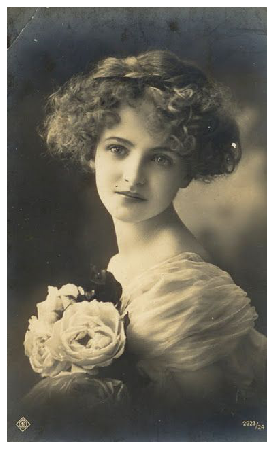

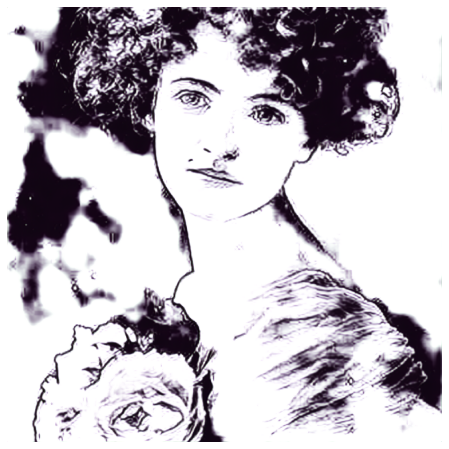

In [ ]:
#@title ARTLINE IMAGES  { run: "auto" }
import glob

files = sorted(glob.glob("%s/*.jpg" % image_folder))
file_idx = 7 #@param {type:"slider", min:0, max:25, step:1}

img = PIL.Image.open(files[file_idx]).convert("RGB")
img_t = T.ToTensor()(img)
img_fast = Image(img_t)
show_image(img_fast, figsize=(8,8), interpolation='nearest');

p,img_hr,b = learn.predict(img_fast)
Image(img_hr).show(figsize=(8,8))